# **CONTROLLING METFORMIN**

In [1]:
import numpy as np
try:
    import controlSBML as ctl
except:
    !pip install controlSBML
    import controlSBML as ctl
try:
    import control
except:
    !pip install control
    import control
#
from controlSBML import ControlSBML, constants
from controlSBML.grid import Grid
import matplotlib.pyplot as plt
from typing import Optional, List

# Helpers

In [2]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 5, 500)
WOLF_URL = constants.WOLF_URL

In [3]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None, figsize=[5,5],
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    _, yv = control.step_response(tf, T=times)
    _ = ax.plot(times, yv)
    if xlim is not None:
        ax.set_xlim(xlim)
    _ = ax.set_title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


In [4]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [5]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [6]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      ax=None,
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"FFL poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"FFL zeros: {ppComplex(zeros)}"
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


# 1. System Description and Control Objecives

## Open loop system

This notebook explores the possibility of an external controller (e.g., an intelligent patch) to manage levels of metformin in the treatment of diabetes. The analysis develops a closed loop system using the model developed in "Physiologically based metformin pharmacokinetics model of mice and scale-up to humans for the estimation of concentrations in various tissues" by Darta Maija Zake, Janis Kurlovics, Linda Zaharenko, Vitalijs Komasilovs, Janis Klovins, Egils Stalidzans in PLOS ONE , 4/ 2021 , Volume 16 , Issue 4 , pages: e0249594 , DOI: 10.1371/journal.pone.0249594. The model developed in this paper are quite accurate in predicting metformin levels, as shown below.

This is BioModels BIOMD0000001039.

<img src="https://raw.github.com/ModelEngineering/controlSBML/main/examples/images/metformin_overview.png"
     alt="Markdown Monster icon" 
     width="800" height="1000"
     style="float: left; margin-right: 10px;" />

## Measured output

The biological problem we address is controlling metformin in kidney tissue (``mKidneyTissue``), a key consideration since the only case where metformin is counterindicated for the treatment of diabetes is in the case of kidney disease. The idea is to explore the feasibility of an "intelligent patch" that would regulate the level of metformin in kidney tissue, possibly to better manage diabetes patients with kidney disease.
* Regulate metformin in kidney tissue (``mKidneyTissue``)
* Very fast settling times

## Requirements for effective control

1. The system must be stable
1. Low bias in the regulation
1. Short settling times, which will be quantified later.

## Time course for open loop system

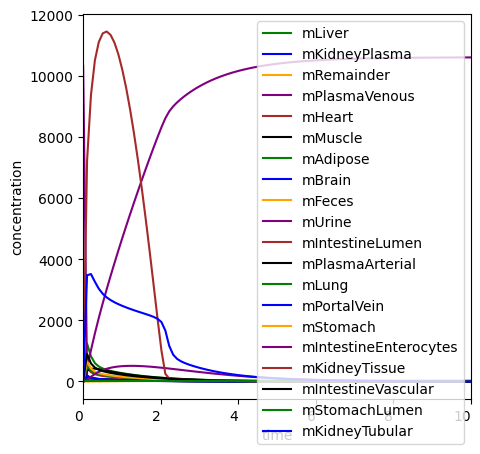

In [7]:
URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
CTLSB = ControlSBML(URL)
_ = CTLSB.plotModel(figsize=(5,5))

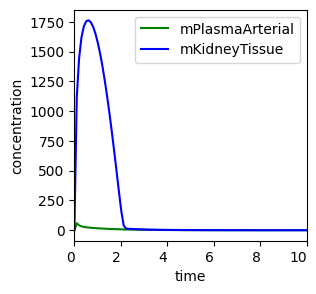

In [8]:
URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
CTLSB = ControlSBML(URL)
_ = CTLSB.plotModel(selections=["mPlasmaArterial", "mKidneyTissue"], figsize=(3,3))

# Step 2. Control input and operating region

In [9]:
INPUT_NAME = "mPlasmaArterial"
OUTPUT_NAME = "mKidneyTissue"
CTLSB = ControlSBML(URL, figsize=(5, 5), times=np.linspace(0, 2000, 20000), markers=False,
                   input_name="mPlasmaArterial", output_name="mKidneyTissue")  # Specify default value of options

## Plot the staircase response

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.



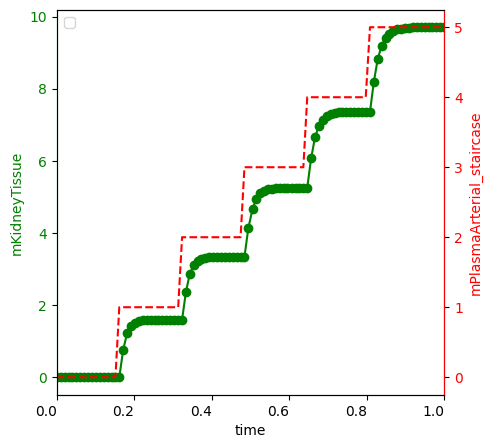

In [10]:
staircase_result = CTLSB.plotStaircaseResponse(initial_value=0, final_value=5, num_step=5,
    times=np.linspace(0, 1, 100))

## Operating region

* **control input**: ``mPlasmaArterial`` is in [0, 5]
* **measured output**: ``mKidneyTissue`` is in [0, 10]
* **step duration**: Step durations are a bit under 0.2 s

## Effectiveness of control

* **directional effect**: ``mKidneyTissue`` is monotone increasing in ``mPlasmaArterial`` over the operating region
* **linearity**: linear with a multiplier of about 2
* **settling time**: Settling times are less than 0.1 s

# Step 3. System identification

## How well does the transfer function predict behavior?

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is mPlasmaArterial and the output is mKidneyTissue. mPlasmaArterial is varied over the operating region of [0, 5]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns an object with several properties of interest: Timeseries (a dataframe with the data plotted) and AntimonyBuilder (the Antimony code run to produce the fitting data).

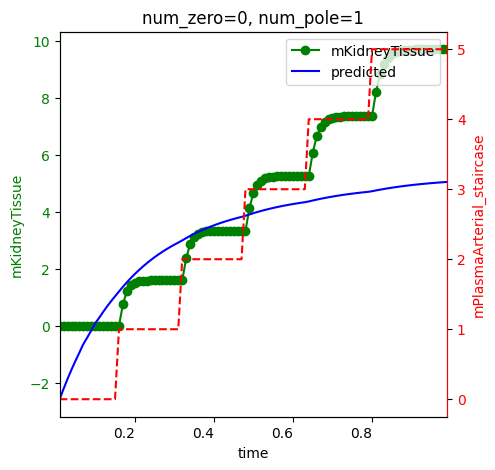

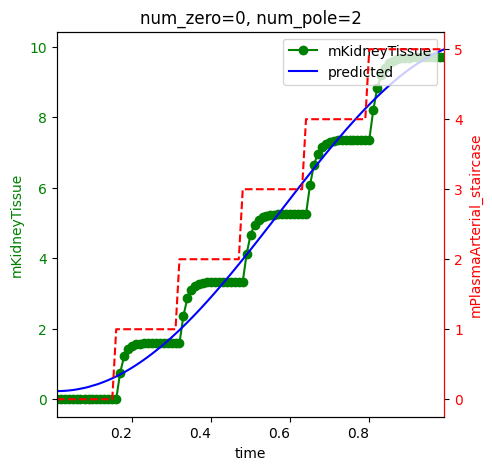

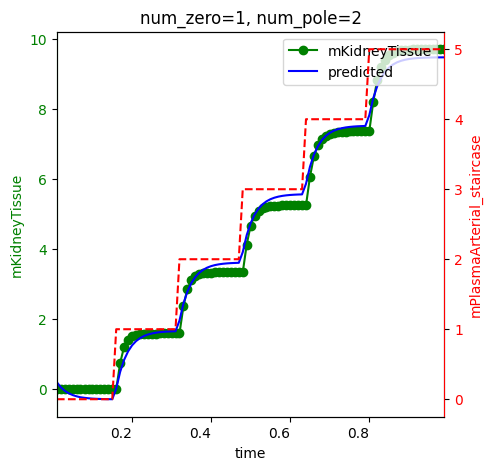

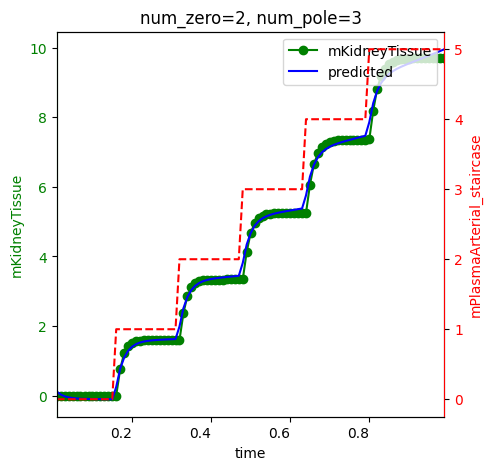

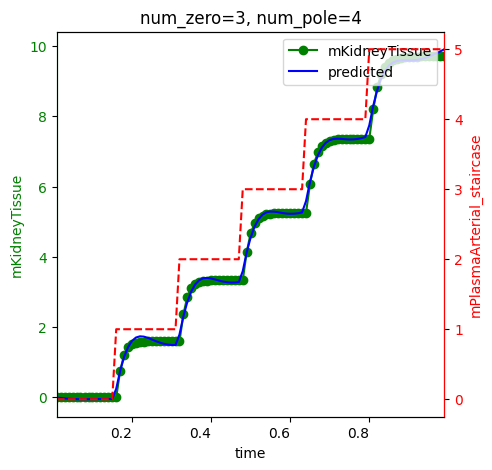

In [11]:
for num_zero, num_pole in [(0,1), (0, 2), (1, 2), (2,3), (3,4)]:
    fit_result = CTLSB.plotTransferFunctionFit(num_zero=num_zero, num_pole=num_pole, initial_value=0,
            final_value=5, times=np.linspace(0, 1, 100), title=f"num_zero={num_zero}, num_pole={num_pole}")

In [12]:
fit_result = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=2, initial_value=0,
            final_value=5, times=np.linspace(0, 1, 100), title=f"num_zero={num_zero}, num_pole={num_pole}", is_plot=False)

The most accurate predictions occur with num_zer0=3, num_pole=4. However, this creates a system that will be more of a challenge to design a controller. I use num_zero=1, num_pole=2. Models with fewer zeros and poles are much less accurate.

## Transfer Function Poles, DC gain

In [13]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([267.14144611,   3.78228102]), array([  3.95596418, 136.85793539,   2.05606907]))

In [14]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-3.45803125e+01+0.j, -1.50299119e-02+0.j]), array([-0.01415835+0.j]))

In [15]:
TRANSFER_FUNCTION.dcgain()

1.839569043203681

* **oscillations**: There is no pole with a non-zero imaginary part, and so no oscillations are expected in the open loop system.
* **stability**: There is no positive pole, and so we don't have a stability problem.
* **dominant pole**: $\approx -0.015$
* **settling times**: The dominant pole is very close to zero, which suggests a problem with long settling times.

# Step 4. Theory-based design

## Root locus plot

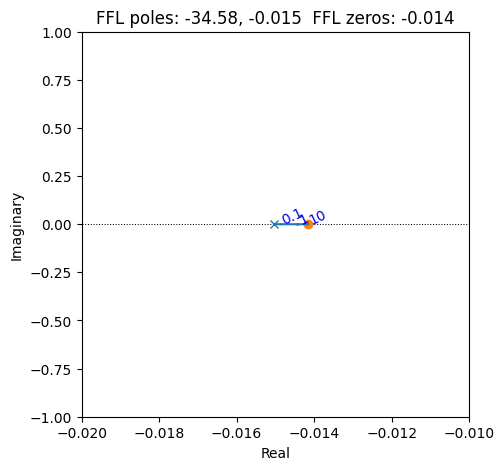

In [16]:
_ = plotRootLocusWithGains(TRANSFER_FUNCTION, [0.1, 1, 10], markersize_multiplier=1, xlim=[-0.02, -0.01])

* **branches**: There are two poles, and so there are two branches. The branch starting at $\approx -35$ extends to negative infinity. This can be ignored since these closed loop poles will not be dominant.
* **dominant closed loop pole**: The dominant closed loop pole appears between -0.014 and -0.015.
* **scale the x-axis**: We need to focus on the dominant pole in the closed loop system, and so this will be the branch starting from the dominant open loop pole.

## Challenges and design

* **challenge with controlling the system**: We don't benefit with moving the pole from -0.015 and moves to -0.014.
* **design strategy**: The close proximity of the pole and zero suggests that there likely is a large amount of pole-zero cancelation. Our hope is that the effect of this branch will be small. Given this, we focus on the branch that moves left from -34.48. To avoid having an excessively large $k_P$, we consider PI-control. We will use PI control to eliminate bias.

In [17]:
# Transfer function for the system with one pole and no zero
REVISED_TRANSFER_FUNCTION = control.zpk([], [-34.58], TRANSFER_FUNCTION.dcgain())
REVISED_TRANSFER_FUNCTION

TransferFunction(array([1.83956904]), array([ 1.  , 34.58]))

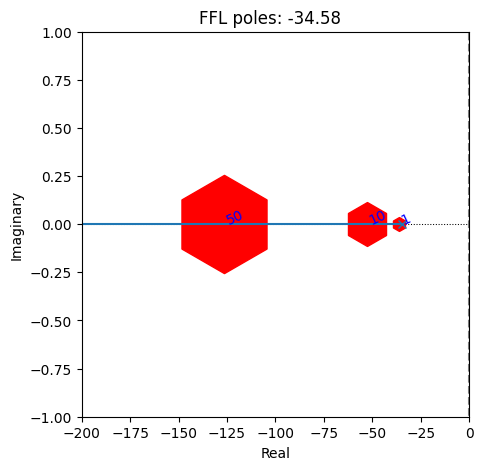

In [18]:
_ = plotRootLocusWithGains(REVISED_TRANSFER_FUNCTION, [1, 10, 50], xlim=[-200, 0])

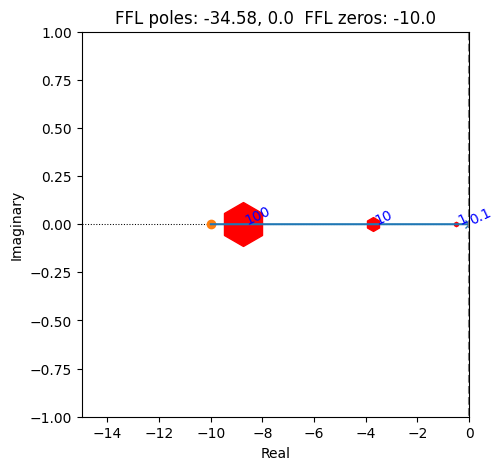

In [19]:
# Root locus plot for PI control
rIP = 10 # ratio of integral control to proportional, kI/kP
controller_tf = control.TransferFunction([1, rIP], [1, 0]) 
_ = plotRootLocusWithGains(REVISED_TRANSFER_FUNCTION*controller_tf, [0.1, 1, 10, 100], markersize_multiplier=10, xlim=[-15, 0])

* **interpretation**: The $r_{IP} = k_{I} / k_{P}$ should be at least 10.

# Step 5. Testbed-based design

## Proposed design

I used a grid search to explore parameters for the PI design. The theory provided guidance as to the structure of the grid since I was looking for approximately a 10:1 ratio between integral and proportional control (assuming pole-zero cancellation). The grid search covered a wider range, but the result was vary close to the 10:1 ratio indicated from theory.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' wh

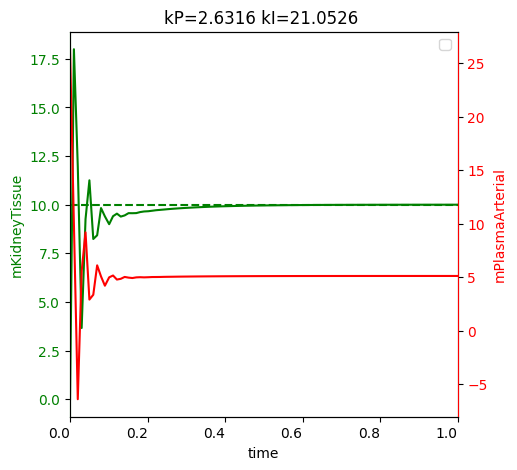

In [20]:
grid = Grid()
grid.addAxis("kP", min_value=0, max_value=50, num_coordinate=20)
grid.addAxis("kI", min_value=0.000, max_value=100, num_coordinate=20)
_ = CTLSB.plotGridDesign(grid, setpoint=10, times=np.linspace(0, 1, 100), is_plot=True)

## Alternatives designs considered

I considered a full PID design. This required more computation, and I ended up with the same PI design.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' wh

CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with

Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.680712 and h = 1.78037e-10, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.230016 and h = 1.52977e-09, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.55716 and h = 1.46246e-09, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.424316 and h = 7.29531e-11, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.545704 and h = 4.17472e-09, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.358468 and h = 2.51569e-10, the error te

CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual

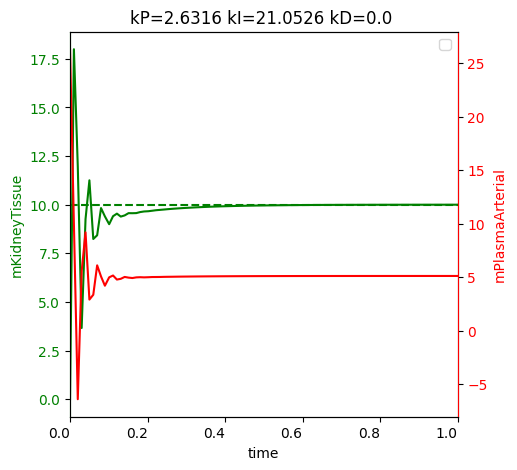

In [21]:
grid = Grid()
grid.addAxis("kP", min_value=0, max_value=50, num_coordinate=20)
grid.addAxis("kI", min_value=0.000, max_value=100, num_coordinate=20)
grid.addAxis("kD", min_value=0.000, max_value=0.1, num_coordinate=10)
_ = CTLSB.plotGridDesign(grid, setpoint=10, times=np.linspace(0, 1, 100))

## Fine Tuning

There are some initial oscillations ("ringing") to the step response. These can be reduced by reducting $k_I$, although settling times will be a bit longer.

In [26]:
?CTLSB.plotDesign

Signature:
CTLSB.plotDesign(
    kP_spec: bool = False,
    kI_spec: bool = False,
    kD_spec: bool = False,
    kF_spec: bool = False,
    setpoint: Optional[float] = 1,
    sign: Optional[float] = -1,
    times: Optional[numpy.ndarray] = None,
    num_process: Optional[int] = -1,
    num_restart: Optional[int] = 1,
    selections: Optional[List[str]] = None,
    min_parameter_value: float = 0,
    max_parameter_value: float = 10,
    num_coordinate: int = 3,
    is_report: bool = False,
    **kwargs,
) -> controlSBML.control_sbml.DesignResult
Docstring:
Plots the results of a closed loop design. The design is specified by the parameters
kP_spec, kI_spec, kD_spec, and kF_spec.
   None or False: do not include the parameter
   True: include the parameter and find a value
   float: use this value for the parameter.
Persists the closed loop design (kP, kI, kD, kF) if a design is found.

Args:
    kP_spec: float (specification of proportional gain)
    kI_spec: float (specification of in

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]


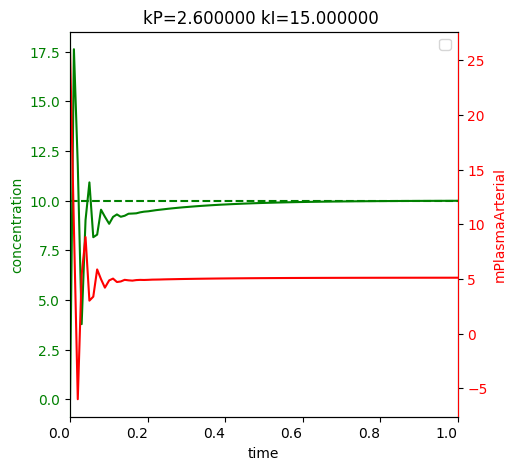

In [31]:
fit_result = CTLSB.plotDesign(kP_spec=2.6, kI_spec=15, setpoint=10, times=np.linspace(0, 1, 100))

## Comments on the final design

The final design is a PI-controller with $k_P =2.6, k_I=15$.
This has a settling time of less than 0.4 s and only moderate ringing.